# Introduction

* https://towardsdatascience.com/auto-encoder-what-is-it-and-what-is-it-used-for-part-1-3e5c6f017726

* Autoencoder is an unsupervised artificial neural network that learns how to efficiently compress and encode data then learns how to reconstruct the data back from the reduced encoded representation to a representation that is as close to the original input as possible.

* Autoencoder, by design, reduces data dimensions by learning how to ignore the noise in the data.

* The network architecture for autoencoders can vary between a simple FeedForward network, LSTM network or Convolutional Neural Network depending on the use case. 

# Autoencoder for Anomaly Detection:

* If you have correlated input data, the autoencoder method will work very well because the encoding operation relies on the correlated features to compress the data. 

* It seems correlation is often the major reason for compression. Imagine the picture of PCA. 

* Let's train an autoencoder on the MNIST dataset using a simple FeedForward neural network. We can achieve this by building a simple 6 layers network as below:

In [1]:
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras import optimizers
from keras.optimizers import Adam

(x_train, y_train), (x_test, y_test) = mnist.load_data()
train_x = x_train.reshape(60000, 784) / 255
val_x = x_test.reshape(10000, 784) / 255

autoencoder = Sequential()
autoencoder.add(Dense(512,  activation='elu', input_shape=(784,)))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(10,    activation='linear', name="bottleneck"))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(512,  activation='elu'))
autoencoder.add(Dense(784,  activation='sigmoid'))
autoencoder.compile(loss='mean_squared_error', optimizer = Adam())
trained_model = autoencoder.fit(train_x, train_x, batch_size=1024, epochs=10, verbose=1, validation_data=(val_x, val_x))
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
encoded_data = encoder.predict(train_x)  # bottleneck representation
decoded_output = autoencoder.predict(train_x)        # reconstruction
encoding_dim = 10

# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-3](encoded_input)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.0745 - val_loss: 0.0501
Epoch 2/10
60000/60000 [==============================] - 1s 17us/step - loss: 0.0416 - val_loss: 0.0347
Epoch 3/10
60000/60000 [==============================] - 1s 18us/step - loss: 0.0314 - val_loss: 0.0280
Epoch 4/10
60000/60000 [==============================] - 1s 18us/step - loss: 0.0270 - val_loss: 0.0253
Epoch 5/10
60000/60000 [==============================] - 1s 17us/step - loss: 0.0249 - val_loss: 0.0237
Epoch 6/10
60000/60000 [==============================] - 1s 17us/step - loss: 0.0234 - val_loss: 0.0223
Epoch 7/10
60000/60000 [==============================] - 1s 17us/step - loss: 0.0222 - val_loss: 0.0212
Epoch 8/10
60000/60000 [======

* As you can see in the output, the last reconstruction loss/error for the validation set is 0.0193 which is great. Now, if I pass any normal image from the MNIST dataset, the reconstruction loss will be very low (< 0.02) BUT if I tried to pass any other different image (outlier or anomaly), we will get a high reconstruction loss value because the network failed to reconstruct the image/input that is considered an anomaly.

* Notice in the code above, you can use only the encoder part to compress some data or images and you can also only use the decoder part to decompress the data by loading the decoder layers.

* Let’s do some anomaly detection. The code below uses two different images to predict the anomaly score (reconstruction error) using the autoencoder network we trained above. the first image is from the MNIST and the result is 5.43209. This means that the image is not an anomaly. The second image I used, is a completely random image that doesn’t belong to the training dataset and the results were: 6789.4907. This high error means that the image is an anomaly. The same concept applies to any type of dataset.

In [ ]:
%matplotlib inline
from keras.preprocessing import image
# if the img.png is not one of the MNIST dataset that the model was trained on, the error will be very high.
img = image.load_img("./img.png", target_size=(28, 28), color_mode = "grayscale")
input_img = image.img_to_array(img)
inputs = input_img.reshape(1,784)
target_data = autoencoder.predict(inputs)
dist = np.linalg.norm(inputs - target_data, axis=-1)
print(dist)

# Image Denoising:

Denoising or noise reduction is the process of removing noise from a signal. This can be an image, audio or a document. You can train an Autoencoder network to learn how to remove noise from pictures. In order to try out this use case, let’s re-use the famous MNIST dataset and let’s create some synthetic noise in the dataset. The code below will simply add some noise to the dataset then plot a few pictures to make sure that we’ve successfully created them.
# The code below is from the Keras Blogs
# https://blog.keras.io/building-autoencoders-in-keras.html

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

#Print one image to see the noise
plt.imshow(x_test_noisy[1].reshape(28, 28))

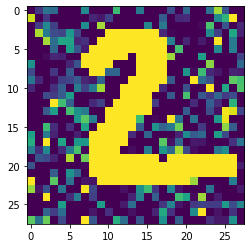

In [6]:
# The code below is from the Keras Blogs
# https://blog.keras.io/building-autoencoders-in-keras.html
import matplotlib.pyplot as plt
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

#Print one image to see the noise
plt.imshow(x_test_noisy[1].reshape(28, 28))


The output of the code above is the image below, which is pretty noisy and fuzzy:

In this example, let’s build a Convolutional Autoencoder Neural Network. I will walk through each line of building the network:
First, we define the input layer and the dimensions of the input data. MNIST dataset has images that are reshaped to be 28 X 28 in dimensions. Since the images are greyscaled, the colour channel of the image will be 1 so the shape is (28, 28, 1).
The second layer is the convolution layer, this layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. 32 is the number of output filters in the convolution and (3, 3) is the kernel size.
After each convolution layer, we use MaxPooling function to reduce the dimensions. The (28, 28, 32) is reduced by a factor of two so it will be (14, 14, 32) after the first MaxPooling then (7, 7, 32) after the second MaxPooling. This is the encoded representation of the image.

In [ ]:
autoencoder = Sequential()
autoencoder.add(Dense(512,  activation='elu', input_shape=(784,)))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(10,    activation='linear', name="bottleneck"))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(512,  activation='elu'))
autoencoder.add(Dense(784,  activation='sigmoid'))

In [7]:
input_img = Input(shape=(28, 28, 1))

nn = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
nn = MaxPooling2D((2, 2), padding='same')(nn)
nn = Conv2D(32, (3, 3), activation='relu', padding='same')(nn)
encoded = MaxPooling2D((2, 2), padding='same')(nn)

The code below is the reconstruction part of the original digits. This is where the network actually learns how to remove the noise from the input images. We use UpSampling function to rebuild the images to the original dimensions (28, 28)

In [8]:
nn = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
nn = UpSampling2D((2, 2))(nn)
nn = Conv2D(32, (3, 3), activation='relu', padding='same')(nn)
nn = UpSampling2D((2, 2))(nn)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(nn)

NameError: name 'Conv2D' is not defined

Now, the last remaining step is to create the model, compile it then start the training. We do this by running:

In [ ]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta',loss='binary_crossentropy')
autoencoder.fit(x_train_noisy, x_train,
                epochs=50,
                batch_size=256,
                validation_data=(x_test_noisy, x_test))

After the training is complete, I try to pass one noisy image through the network and the results are quite impressive, the noise was completely removed:

If you scale the ConvNet above, you can use it to denoise any type of images, audio or scanned documents.
In this part of the article, I covered two important use cases for autoencoders and I build two different neural network architectures — CNN and FeedForward. In part 2, I will cover another 2 important use cases for Autoencoders. The first one will be how to use autoencoder with a sequence of data by building an LSTM network and the second use case is a called Variational Autoencoder (VAE) which is mainly used in Generative Models and generating data or images. Stay tuned!

# Autoencoder with sequence data - LSTM

# Variational Autoencoder (VAE)